# Assignment 6B

## Fix the network above:
1. Normal Convolution
2. Spatially Separable Convolution (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
3. Depthwise Separable Convolution
4. Grouped Convolution (use 3x3, 5x5 only)
5. Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)

* You must use all of the 5 above at least once
*  Train this new model for 50 epochs. 
*  Save File as Assignment 6B

##Loading and Preprocessing the Data

### Loading the Cifar10 Datset and plotting 10 classes

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout, concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.utils import plot_model
from IPython.display import SVG
from keras.utils import model_to_dot

from keras.preprocessing.image import ImageDataGenerator

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

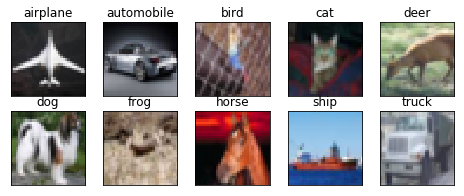

In [58]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Defining Functions to Plot Accuracy and Loss Graphs.

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

###**Type Conversion and Scalling:**
1. Convert the input data type to float32.
2. Normalise the input data within the range of 0 and 9.

###**One Hot Encoding of Labels:**
1. Convert the 1D class arrays of output data into 10 dimesional class matrices - basically one hot encoding.

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

#**Model Creation Using Keras**
The following code defines the architecture/model of our neural network in which we will add layers in the network using keras:
1.   **Initializing a sequential model**: Stack layers on top of one another, it also ensures that the input and output sizes of successive layers are compatible. 
2.   **Adding Convolution Layers**: While adding the first convolution layer we need to specify the input size as well. In the next convolution layers we do not need an input size since they will receive the input size from the preceeding layers.
3. **Adding Max Pooling Layers**: We add them to resuce the dimensions of image extracting the maximum out of the (2,2) pool and pass them forward.
4. **Adding Flatten Layer**: When finally we reach the output size of 1X1X10, we flatten the output channel-wise into output of shape 10 (1-dimension).
5. **Adding Softmax Layer**: This layer converts the last layer outuput into probabolity distribution of 10 classes.



##### Basic Convolution Model Architecture

**1. Total params: 1,172,410**

**2. Trainable params: 1,172,410**

**3. Non-trainable params: 0**

---

###We are getting the validation accuracy = 82.32%
#### After 50 EPOCHS we get the following results:
loss: 0.3176 || acc: 0.8944 || val_loss: 0.5911 || **val_acc: 0.8232** ||

---



In [8]:
########################################
# Define the model
model = Sequential()
########################################

# All shapes are in the form [height, width, num_channels]

# INPUT SIZE : [32, 32, 3] | OUTPUT SIZE : [32, 32, 48] | GRF_of_input : [1, 1]
model.add(Convolution2D(48, (3, 3), padding='same', input_shape=(32, 32, 3))) # 32
model.add(Activation('relu'))

# INPUT SIZE : [32, 32, 48] | OUTPUT SIZE : [30, 30, 48] | GRF_of_input : [3, 3]
model.add(Convolution2D(48, (3, 3))) # 30
model.add(Activation('relu'))

########################################

# INPUT SIZE : [30, 30, 48] | OUTPUT SIZE : [15, 15, 48] | GRF_of_input : [5, 5]
model.add(MaxPooling2D(pool_size=(2, 2))) # 15
model.add(Dropout(0.25))
########################################

# The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's]
# INPUT SIZE : [15, 15, 48] | OUTPUT SIZE : [15, 15, 96] | GRF_of_input : [7, 7]
model.add(Convolution2D(96, (3, 3), padding='same')) # 15
model.add(Activation('relu'))

# INPUT SIZE : [15, 15, 96] | OUTPUT SIZE : [13, 13, 96] | GRF_of_input : [11, 11]
model.add(Convolution2D(96, (3, 3))) # 13
model.add(Activation('relu'))
########################################

# INPUT SIZE : [13, 13, 96] | OUTPUT SIZE : [6, 6, 96] | GRF_of_input : [15, 15]
model.add(MaxPooling2D(pool_size=(2, 2))) # 6
model.add(Dropout(0.25))
########################################

# INPUT SIZE : [6, 6, 96] | OUTPUT SIZE : [6, 6, 192] | GRF_of_input : [19, 19]
model.add(Convolution2D(192, (3, 3), padding='same')) # 6
model.add(Activation('relu'))

# INPUT SIZE : [6, 6, 192] | OUTPUT SIZE : [4, 4, 192] | GRF_of_input : [27, 27]
model.add(Convolution2D(192, (3, 3))) # 4
model.add(Activation('relu'))

########################################
# INPUT SIZE : [4, 4, 192] | OUTPUT SIZE : [2, 2, 192] | GRF_of_input : [35, 35]
model.add(MaxPooling2D(pool_size=(2, 2))) # 2
model.add(Dropout(0.25))
########################################

# INPUT SIZE : [4, 4, 192] | OUTPUT SIZE : [768] | GRF_of_input : [43, 43]
model.add(Flatten()) # 768

########################################

# INPUT SIZE : [192] | OUTPUT SIZE : [512]
model.add(Dense(512)) # 512
model.add(Activation('relu'))
model.add(Dropout(0.5))

# INPUT SIZE : [512] | OUTPUT SIZE : [256]
model.add(Dense(256)) # 256
model.add(Activation('relu'))
model.add(Dropout(0.5))

# INPUT SIZE : [256] | OUTPUT SIZE : [10] 
model.add(Dense(num_classes, activation='softmax')) # 10

########################################

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Printing out the model summary
model.summary()

########################################
# saving the model to reload model with initial weights while trying out different optimizations
model.save_weights('model.h5')
########################################


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_10 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 96)       

Epoch 1/50
  2/390 [..............................] - ETA: 25s - loss: 2.3104 - acc: 0.0820

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  # Remove the CWD from sys.path while we load stuff.


390/390 [==============================] - 20s 51ms/step - loss: 1.9128 - acc: 0.2664 - val_loss: 1.5026 - val_acc: 0.4422
Epoch 2/50
390/390 [==============================] - 20s 50ms/step - loss: 1.4258 - acc: 0.4830 - val_loss: 1.1856 - val_acc: 0.5695
Epoch 3/50
390/390 [==============================] - 20s 51ms/step - loss: 1.1757 - acc: 0.5827 - val_loss: 0.9958 - val_acc: 0.6476
Epoch 4/50
390/390 [==============================] - 20s 51ms/step - loss: 1.0149 - acc: 0.6441 - val_loss: 0.8862 - val_acc: 0.6903
Epoch 5/50
390/390 [==============================] - 20s 51ms/step - loss: 0.8919 - acc: 0.6907 - val_loss: 0.7893 - val_acc: 0.7272
Epoch 6/50
390/390 [==============================] - 20s 51ms/step - loss: 0.8135 - acc: 0.7218 - val_loss: 0.7655 - val_acc: 0.7375
Epoch 7/50
390/390 [==============================] - 20s 51ms/step - loss: 0.7540 - acc: 0.7440 - val_loss: 0.7070 - val_acc: 0.7637
Epoch 8/50
390/390 [==============================] - 20s 50ms/step - los

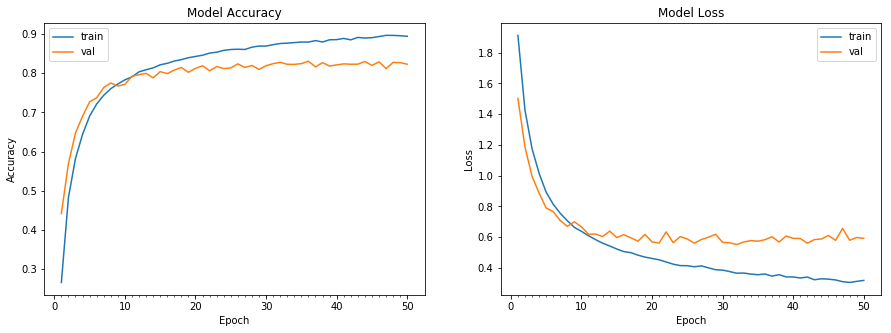

Accuracy on test data is: 82.32


In [10]:
model.load_weights('model.h5')
datagen = ImageDataGenerator(zoom_range=0.0, horizontal_flip=False)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
model.save_weights('model_afterTraining.h5')


### Spatially Separable Convolution (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
* The spatially separable convolution operates on the 2D spatial dimensions of images, i.e. height and width. Conceptually, spatially separable convolution decomposes a convolution into two separate operations. For an example shown below, a Sobel kernel, which is a 3x3 kernel, is divided into a 3x1 and 1x3 kernel.

* Although spatially separable convolutions save cost, it is rarely used in deep learning. One of the main reason is that not all kernels can be divided into two, smaller kernels. If we replace all traditional convolutions by the spatially separable convolution, we limit ourselves for searching all possible kernels during training. The training results may be sub-optimal.
---

**Total params: 1,033,978**

Trainable params: 1,033,978

Non-trainable params: 0

---
### We are getting Validation Accuracy = 81.52%
#### After 50 EPOCHS we get the following results:
loss: 0.5585 - acc: 0.8209 - val_loss: 0.5911 - **val_acc: 0.8152**

---




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 1), input_shape=(32, 32, 3..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (1, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 1))`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (1, 3))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 1), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 48)        480       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 48)        6960      
_________________________________________________________________
activation_17 (Activation)   (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 32, 48)        6960      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 30, 30, 48)        6960      
_________________________________________________________________
activation_18 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 48)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50
390/390 [==============================] - 14s 35ms/step - loss: 1.8756 - acc: 0.2869 - val_loss: 1.4737 - val_acc: 0.4577
Epoch 2/50
390/390 [==============================] - 12s 31ms/step - loss: 1.4261 - acc: 0.4855 - val_loss: 1.1644 - val_acc: 0.5841
Epoch 3/50
390/390 [==============================] - 12s 31ms/step - loss: 1.1980 - acc: 0.5770 - val_loss: 1.0362 - val_acc: 0.6338
Epoch 4/50
390/390 [==============================] - 12s 32ms/step - loss: 1.0750 - acc: 0.6273 - val_loss: 0.9559 - val_acc: 0.6670
Epoch 5/50
390/390 [==============================] - 12s 31ms/step - loss: 0.9885 - acc: 0.6604 - val_loss: 0.8332 - val_acc: 0.7152
Epoch 6/50
390/390 [==============================] - 12s 31ms/step - loss: 0.9106 - acc: 0.6899 - val_loss: 0.7927 - val_acc: 0.7325
Epoch 7/50
390/390 [==============================] - 12s 31ms/step - loss: 0.8621 - acc: 0.7054 - val_loss: 0.8219 - val_acc: 0.7195
Epoch 8/50
390/390 [==============================] - 12s 31ms

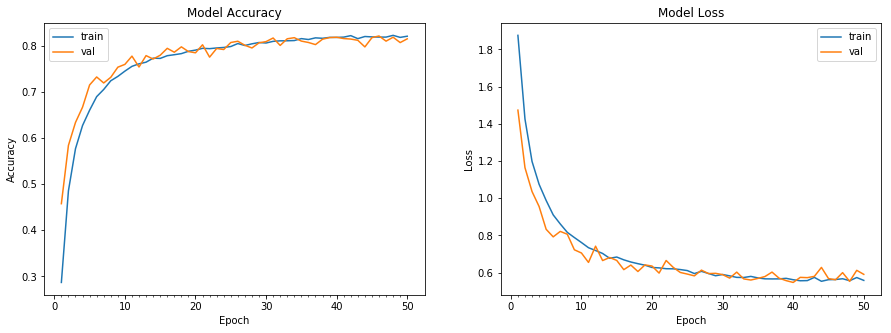

Accuracy on test data is: 81.52


In [0]:
########################################
# Define the model
model = Sequential()
########################################

# All shapes are in the form [height, width, num_channels]

# INPUT SIZE : [32, 32, 3] | OUTPUT SIZE : [32, 32, 48] | GRF_of_input : [1, 1]
model.add(Convolution2D(48, 3, 1, padding='same', input_shape=(32, 32, 3))) # 32
model.add(Convolution2D(48, 1, 3, padding='same', input_shape=(32, 32, 3))) # 32
model.add(Activation('relu'))

# INPUT SIZE : [32, 32, 48] | OUTPUT SIZE : [30, 30, 48] | GRF_of_input : [3, 3]
model.add(Convolution2D(48, 3, 1)) # 30
model.add(Convolution2D(48, 1, 3)) # 30
model.add(Activation('relu'))

########################################

# INPUT SIZE : [30, 30, 48] | OUTPUT SIZE : [15, 15, 48] | GRF_of_input : [5, 5]
model.add(MaxPooling2D(pool_size=(2, 2))) # 15
model.add(Dropout(0.25))
########################################

# The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's]
# INPUT SIZE : [15, 15, 48] | OUTPUT SIZE : [15, 15, 96] | GRF_of_input : [7, 7]
model.add(Convolution2D(96, 3, 1, padding='same')) # 15
model.add(Convolution2D(96, 1, 3, padding='same')) # 15
model.add(Activation('relu'))

# INPUT SIZE : [15, 15, 96] | OUTPUT SIZE : [13, 13, 96] | GRF_of_input : [11, 11]
model.add(Convolution2D(96, 3, 1)) # 13
model.add(Convolution2D(96, 1, 3)) # 13
model.add(Activation('relu'))
########################################

# INPUT SIZE : [13, 13, 96] | OUTPUT SIZE : [6, 6, 96] | GRF_of_input : [15, 15]
model.add(MaxPooling2D(pool_size=(2, 2))) # 6
model.add(Dropout(0.25))
########################################

# INPUT SIZE : [6, 6, 96] | OUTPUT SIZE : [6, 6, 192] | GRF_of_input : [19, 19]
model.add(Convolution2D(192, 3, 1, padding='same')) # 6
model.add(Convolution2D(192, 1, 3, padding='same')) # 6
model.add(Activation('relu'))

# INPUT SIZE : [6, 6, 192] | OUTPUT SIZE : [4, 4, 192] | GRF_of_input : [27, 27]
model.add(Convolution2D(192, 3, 1)) # 4
model.add(Convolution2D(192, 1, 3)) # 4
model.add(Activation('relu'))

########################################
# INPUT SIZE : [4, 4, 192] | OUTPUT SIZE : [2, 2, 192] | GRF_of_input : [35, 35]
model.add(MaxPooling2D(pool_size=(2, 2))) # 2
model.add(Dropout(0.25))
########################################

# INPUT SIZE : [4, 4, 192] | OUTPUT SIZE : [768] | GRF_of_input : [43, 43]
model.add(Flatten()) # 768

########################################

# INPUT SIZE : [192] | OUTPUT SIZE : [512]
model.add(Dense(512)) # 512
model.add(Activation('relu'))
model.add(Dropout(0.5))

# INPUT SIZE : [512] | OUTPUT SIZE : [256]
model.add(Dense(256)) # 256
model.add(Activation('relu'))
model.add(Dropout(0.5))

# INPUT SIZE : [256] | OUTPUT SIZE : [10] 
model.add(Dense(num_classes, activation='softmax')) # 10

########################################

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Printing out the model summary
model.summary()

########################################
# saving the model to reload model with initial weights while trying out different optimizations
model.save_weights('model_Spatially_Separable1.h5')
########################################

########################################################################################################################
model.load_weights('model_Spatially_Separable1.h5')
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
model.save_weights('model_Spatially_Separable1_afterTraining.h5')
########################################################################################################################

### Depthwise Separable Convolution
* The depth wise separable convolutions consist of two steps: depthwise convolutions and 1x1 convolutions.

#### What’s the advantage of doing depthwise separable convolutions? Efficiency?

One needs much less operations for depthwise separable convolutions compared to 2D convolutions.

#### Diadvantage
The depthwise separable convolutions reduces the number of parameters in the convolution. As such, for a small model, the model capacity may be decreased significantly if the 2D convolutions are replaced by depthwise separable convolutions. As a result, the model may become **sub-optimal**. However, if properly used, depthwise separable convolutions can give you the efficiency without dramatically damaging your model performance.

---

**Total params: 788,362**

Trainable params: 788,362

Non-trainable params: 0

---

### We are getting Validation Accuracy = 82.73%

#### After 50 EPOCHS we get the following results:
loss: 0.3261 || acc: 0.8887 || val_loss: 0.5588|| **val_acc: 0.8273**||

---


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 48)        0         
_________________________________________________________________
separable_conv2d_28 (Separab (None, 30, 30, 48)        2784      
_________________________________________________________________
activation_42 (Activation)   (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 96)       

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50
390/390 [==============================] - 26s 68ms/step - loss: 2.1094 - acc: 0.1882 - val_loss: 1.6993 - val_acc: 0.3645
Epoch 2/50
390/390 [==============================] - 26s 66ms/step - loss: 1.5706 - acc: 0.4207 - val_loss: 1.3899 - val_acc: 0.4874
Epoch 3/50
390/390 [==============================] - 26s 66ms/step - loss: 1.3557 - acc: 0.5079 - val_loss: 1.2168 - val_acc: 0.5630
Epoch 4/50
390/390 [==============================] - 26s 66ms/step - loss: 1.2066 - acc: 0.5720 - val_loss: 1.0888 - val_acc: 0.6202
Epoch 5/50
390/390 [==============================] - 26s 66ms/step - loss: 1.0965 - acc: 0.6141 - val_loss: 0.9670 - val_acc: 0.6635
Epoch 6/50
390/390 [==============================] - 26s 66ms/step - loss: 1.0066 - acc: 0.6487 - val_loss: 0.9050 - val_acc: 0.6837
Epoch 7/50
390/390 [==============================] - 26s 66ms/step - loss: 0.9331 - acc: 0.6789 - val_loss: 0.9040 - val_acc: 0.6934
Epoch 8/50
390/390 [==============================] - 26s 67ms

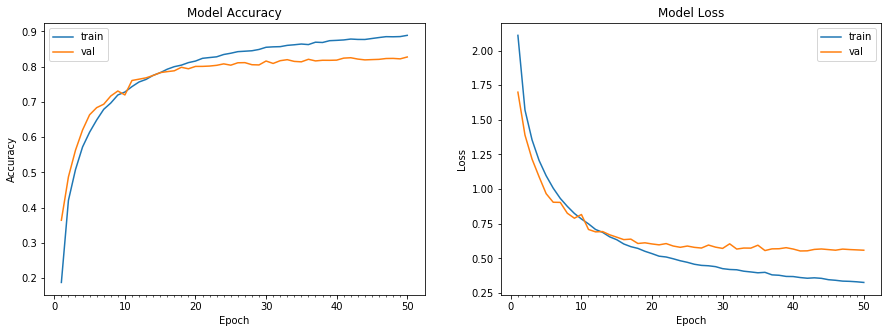

Accuracy on test data is: 82.73


In [15]:
########################################
# Define the model
model = Sequential()
########################################

# All shapes are in the form [height, width, num_channels]

# INPUT SIZE : [32, 32, 3] | OUTPUT SIZE : [32, 32, 48] | GRF_of_input : [1, 1]
model.add(Convolution2D(48, (3, 3), padding='same', input_shape=(32, 32, 3))) # 32
model.add(Activation('relu'))

# INPUT SIZE : [32, 32, 48] | OUTPUT SIZE : [30, 30, 48] | GRF_of_input : [3, 3]
model.add(SeparableConv2D(48, (3, 3))) # 30
model.add(Activation('relu'))

########################################

# INPUT SIZE : [30, 30, 48] | OUTPUT SIZE : [15, 15, 48] | GRF_of_input : [5, 5]
model.add(MaxPooling2D(pool_size=(2, 2))) # 15
model.add(Dropout(0.25))
########################################

# The valid means there is no padding around input or feature map, while same means there are some padding around input or feature map, making the output feature map's size same as the input's]
# INPUT SIZE : [15, 15, 48] | OUTPUT SIZE : [15, 15, 96] | GRF_of_input : [7, 7]
model.add(Convolution2D(96, (3, 3), padding='same')) # 15
model.add(Activation('relu'))

# INPUT SIZE : [15, 15, 96] | OUTPUT SIZE : [13, 13, 96] | GRF_of_input : [11, 11]
model.add(SeparableConv2D(96, (3, 3))) # 13
model.add(Activation('relu'))
########################################

# INPUT SIZE : [13, 13, 96] | OUTPUT SIZE : [6, 6, 96] | GRF_of_input : [15, 15]
model.add(MaxPooling2D(pool_size=(2, 2))) # 6
model.add(Dropout(0.25))
########################################

# INPUT SIZE : [6, 6, 96] | OUTPUT SIZE : [6, 6, 192] | GRF_of_input : [19, 19]
model.add(Convolution2D(192, (3, 3), padding='same')) # 6
model.add(Activation('relu'))

# INPUT SIZE : [6, 6, 192] | OUTPUT SIZE : [4, 4, 192] | GRF_of_input : [27, 27]
model.add(SeparableConv2D(192, (3, 3))) # 4
model.add(Activation('relu'))

########################################
# INPUT SIZE : [4, 4, 192] | OUTPUT SIZE : [2, 2, 192] | GRF_of_input : [35, 35]
model.add(MaxPooling2D(pool_size=(2, 2))) # 2
model.add(Dropout(0.25))
########################################

# INPUT SIZE : [4, 4, 192] | OUTPUT SIZE : [768] | GRF_of_input : [43, 43]
# model.add(Convolution2D(num_classes, (2, 2))) # 15
model.add(Flatten()) # 768
########################################

# INPUT SIZE : [192] | OUTPUT SIZE : [512]
model.add(Dense(512)) # 512
model.add(Activation('relu'))
model.add(Dropout(0.5))

# INPUT SIZE : [512] | OUTPUT SIZE : [256]
model.add(Dense(256)) # 256
model.add(Activation('relu'))
model.add(Dropout(0.5))

# INPUT SIZE : [256] | OUTPUT SIZE : [10] 
model.add(Dense(num_classes, activation='softmax')) # 10

########################################

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Printing out the model summary
model.summary()

########################################
# saving the model to reload model with initial weights while trying out different optimizations
model.save_weights('model_Depth_Separable1.h5')
########################################

########################################################################################################################
model.load_weights('model_Depth_Separable1.h5')
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
model.save_weights('model_Depth_Separable1_afterTraining.h5')
########################################################################################################################

### Grouped Convolution
* Grouped convolutions were used in Alexnet so that a deep neural network can be trained on less powerful GPUs with smaller RAM available at that time.
* Model parallelism: here we try to parallelize the model such that we can take in as much as data as possible. Grouped convolutions enable efficient model parallelism, so much so that Alexnet was trained on GPUs with only 3GB RAM.
* With grouped convolutions, we can build networks as wide as we want. Take one modular block of filter group and replicate them - our network learns a varied set of low level and high level features.

---

### Grouped Convolution (use 3x3, 5x5 only)
We used Keras functional API - for defining complex models.

**Total params: 1,196,794**

Trainable params: 1,196,794

Non-trainable params: 0

---

### We are getting Validation Accuracy = 82.02%

#### After 50 EPOCHS we get the following results:
loss: 0.3521 || acc: 0.8830 || val_loss: 0.5875 || **val_acc: 0.8202**||

---


Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 32, 32, 48)   1344        input_24[0][0]                   
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 32, 32, 48)   3648        input_24[0][0]                   
__________________________________________________________________________________________________
activation_177 (Activation)     (None, 32, 32, 48)   0           conv2d_122[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50
390/390 [==============================] - 28s 71ms/step - loss: 1.9032 - acc: 0.2691 - val_loss: 1.4877 - val_acc: 0.4514
Epoch 2/50
390/390 [==============================] - 25s 64ms/step - loss: 1.4447 - acc: 0.4707 - val_loss: 1.2193 - val_acc: 0.5493
Epoch 3/50
390/390 [==============================] - 25s 64ms/step - loss: 1.2186 - acc: 0.5631 - val_loss: 1.0431 - val_acc: 0.6283
Epoch 4/50
390/390 [==============================] - 25s 64ms/step - loss: 1.0652 - acc: 0.6249 - val_loss: 0.9482 - val_acc: 0.6655
Epoch 5/50
390/390 [==============================] - 25s 64ms/step - loss: 0.9724 - acc: 0.6622 - val_loss: 0.8562 - val_acc: 0.7048
Epoch 6/50
390/390 [==============================] - 25s 64ms/step - loss: 0.8808 - acc: 0.6938 - val_loss: 0.8542 - val_acc: 0.7003
Epoch 7/50
390/390 [==============================] - 25s 64ms/step - loss: 0.8169 - acc: 0.7206 - val_loss: 0.7808 - val_acc: 0.7335
Epoch 8/50
390/390 [==============================] - 25s 64ms

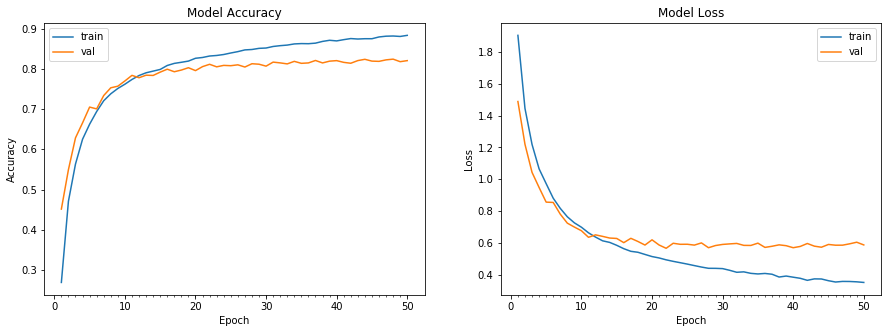

Accuracy on test data is: 82.02


In [62]:
from keras.layers import Input, Dense
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(32, 32, 3))

########################################
x1 = Convolution2D(48, (3, 3), padding='same')(inputs)
x1 = Activation('relu')(x1)

y1 = Convolution2D(48, (5, 5), padding='same')(inputs)
y1 = Activation('relu')(y1)

x = concatenate([x1, y1], axis=3)

x = Convolution2D(48, (3, 3))(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
########################################

x = Convolution2D(96, (3, 3), padding='same')(x)
x = Activation('relu')(x)

x = Convolution2D(96, (3, 3))(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
########################################
x = Convolution2D(192, (3, 3), padding='same')(x)
x = Activation('relu')(x)

x = Convolution2D(192, (3, 3))(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
########################################
x = Flatten()(x)

x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

########################################
plot_model(model, to_file='model_GroupedConvolution1_plot.png', show_shapes=True, show_layer_names=True)
########################################

# saving the model to reload model with initial weights while trying out different optimizations
model.save_weights('model_GroupedConvolution1.h5')
########################################

########################################################################################################################
model.load_weights('model_GroupedConvolution1.h5')
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
model.save_weights('model_GroupedConvolution1_afterTraining.h5')
########################################################################################################################

### Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 

We used Keras functional API - for defining complex models.

**Total params: 1,196,794**

Trainable params: 1,196,794

Non-trainable params: 0

---

### We are getting Validation Accuracy = 81.85%

#### After 50 EPOCHS we get the following results:
loss: 0.4108 || acc: 0.8610 || val_loss: 0.5725 || **val_acc: 0.8185**||

---

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 32, 32, 48)   1344        input_25[0][0]                   
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 32, 32, 48)   3648        input_25[0][0]                   
__________________________________________________________________________________________________
activation_186 (Activation)     (None, 32, 32, 48)   0           conv2d_129[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`


Epoch 1/50
390/390 [==============================] - 29s 76ms/step - loss: 1.9617 - acc: 0.2372 - val_loss: 1.6645 - val_acc: 0.3701
Epoch 2/50
390/390 [==============================] - 26s 68ms/step - loss: 1.5634 - acc: 0.4207 - val_loss: 1.3618 - val_acc: 0.5006
Epoch 3/50
390/390 [==============================] - 27s 68ms/step - loss: 1.3397 - acc: 0.5168 - val_loss: 1.1891 - val_acc: 0.5704
Epoch 4/50
390/390 [==============================] - 26s 68ms/step - loss: 1.1757 - acc: 0.5852 - val_loss: 1.0361 - val_acc: 0.6260
Epoch 5/50
390/390 [==============================] - 26s 67ms/step - loss: 1.0592 - acc: 0.6292 - val_loss: 0.9790 - val_acc: 0.6646
Epoch 6/50
390/390 [==============================] - 26s 68ms/step - loss: 0.9663 - acc: 0.6638 - val_loss: 0.8273 - val_acc: 0.7173
Epoch 7/50
390/390 [==============================] - 26s 67ms/step - loss: 0.8901 - acc: 0.6922 - val_loss: 0.7803 - val_acc: 0.7248
Epoch 8/50
390/390 [==============================] - 26s 67ms

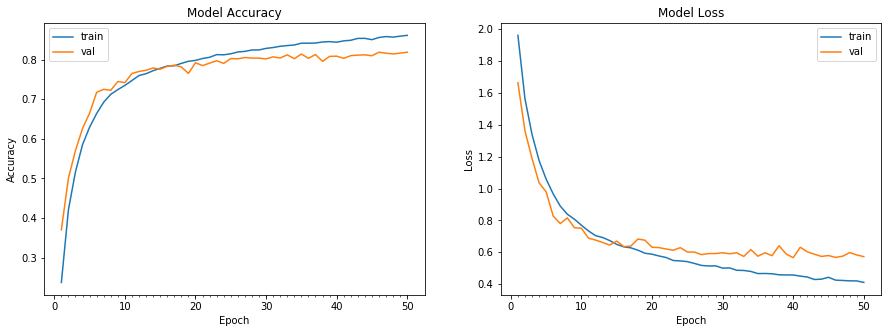

Accuracy on test data is: 81.85


In [64]:
from keras.layers import Input, Dense
from keras.models import Model

# This returns a tensor
inputs = Input(shape=(32, 32, 3))

########################################
x1 = Convolution2D(48, (3, 3), dilation_rate=(1, 1), padding='same')(inputs)
x1 = Activation('relu')(x1)

y1 = Convolution2D(48, (5, 5), dilation_rate=(2, 2), padding='same')(inputs)
y1 = Activation('relu')(y1)

x = concatenate([x1, y1], axis=3)

x = Convolution2D(48, (3, 3))(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
########################################

x = Convolution2D(96, (3, 3), padding='same')(x)
x = Activation('relu')(x)

x = Convolution2D(96, (3, 3))(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
########################################
x = Convolution2D(192, (3, 3), padding='same')(x)
x = Activation('relu')(x)

x = Convolution2D(192, (3, 3))(x)
x = Activation('relu')(x)

x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
########################################
x = Flatten()(x)

x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

########################################
plot_model(model, to_file='model_GroupedConvolution2_plot.png', show_shapes=True, show_layer_names=True)
########################################

# saving the model to reload model with initial weights while trying out different optimizations
model.save_weights('model_GroupedConvolution2.h5')
########################################

########################################################################################################################
model.load_weights('model_GroupedConvolution2.h5')
datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))
model.save_weights('model_GroupedConvolution2_afterTraining.h5')
########################################################################################################################